This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf


from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
print("The Tensorflow is", tf.__version__)

The Tensorflow is 2.15.0


# Sentiment analysis
This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review. This is an example of binary—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review](https://ai.stanford.edu/%7Eamaas/data/sentiment/) Dataset that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

**Download and explore the IMDB dataset**
Let's download and extract the dataset, then explore the directory structure.

In [6]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

datasets = tf.keras.utils.get_file("aclImdb_v1", url,
                                   untar = True, cache_dir='.',
                                   cache_subdir='')

datasets_dir =os.path.join(os.path.dirname(datasets),'aclImdb')

In [7]:
os.listdir(datasets_dir)

['imdbEr.txt', 'train', 'imdb.vocab', 'README', 'test']

In [9]:
train_dir = os.path.join(datasets_dir,'train')
os.listdir(train_dir)

['urls_pos.txt',
 'labeledBow.feat',
 'urls_unsup.txt',
 'unsup',
 'urls_neg.txt',
 'unsupBow.feat',
 'neg',
 'pos']

In [11]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## Load the dataset
Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful `text_dataset_from_directory` utility, which expects a directory structure as follows.


To prepare a dataset for binary classification, you will need two folders on disk, corresponding to ``class_a`` and ``class_b``. These will be the positive and negative movie reviews, which can be found in ``aclImdb/train/pos`` and ``aclImdb/train/neg``. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [12]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

Next, you will use the text_dataset_from_directory utility to create a labeled tf.data.Dataset. tf.data is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: train, validation, and test.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the validation_split argument below.

In [15]:
batch_size=  32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed= seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [16]:
for text_batch , label_batch in raw_train_ds:
  for i in range(30):
    print('Review', text_batch.numpy()[i])
    print('Label', label_batch.numpy()[i])

Streaming output truncated to the last 5000 lines.
Review b"i rate this movie with 3 skulls, only coz the girls knew how to scream, this could've been a better movie, if actors were better, the twins were OK, i believed they were evil, but the eldest and youngest brother, they sucked really bad, it seemed like they were reading the scripts instead of acting them.... spoiler: if they're vampire's why do they freeze the blood? vampires can't drink frozen blood, the sister in the movie says let's drink her while she is alive....but then when they're moving to another house, they take on a cooler they're frozen blood. end of spoiler<br /><br />it was a huge waste of time, and that made me mad coz i read all the reviews of how this movie was great, how many awards this movie won, and this movie was f****ing s**t!!!!"
Label 0
Review b"A Vow to Cherish is a wonderful movie. It's based on a novel of the same title, which was equally good, though different from the film. Really made you think a

In [17]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [18]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## Preparation of Dataset
Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization layer`.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.



In [19]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a TextVectorization layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the output_mode to int to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values

In [20]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [21]:
#make as text-only dataset (without labels) then call adapt
train_text = raw_train_ds.map(lambda x,y:x)
vectorize_layer.adapt(train_text)

In [22]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [25]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [26]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [27]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Configure the dataset for performance
These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the data performance guide.



In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create a Model


In [29]:
embedding_dim = 16

In [30]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [31]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [32]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 12s 18ms/step - loss: 0.6640 - binary_accuracy: 0.6942 - val_loss: 0.6139 - val_binary_accuracy: 0.7718
Epoch 2/10
625/625 [==============================] - 7s 12ms/step - loss: 0.5467 - binary_accuracy: 0.8023 - val_loss: 0.4968 - val_binary_accuracy: 0.8220
Epoch 3/10
625/625 [==============================] - 6s 9ms/step - loss: 0.4430 - binary_accuracy: 0.8454 - val_loss: 0.4186 - val_binary_accuracy: 0.8468
Epoch 4/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3767 - binary_accuracy: 0.8665 - val_loss: 0.3730 - val_binary_accuracy: 0.8606
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3351 - binary_accuracy: 0.8795 - val_loss: 0.3443 - val_binary_accuracy: 0.8670
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3045 - binary_accuracy: 0.8881 - val_loss: 0.3255 - val_binary_accuracy: 0.8712
Epoch 7/10
625/625 [==============================] - 5s 8ms

## Evaluate Model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.




In [33]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 6s 8ms/step - loss: 0.3100 - binary_accuracy: 0.8740
Loss:  0.30996376276016235
Accuracy:  0.8740400075912476


In [34]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

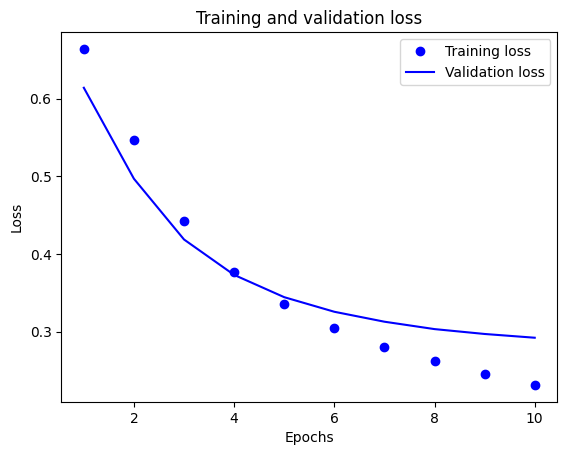

In [35]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

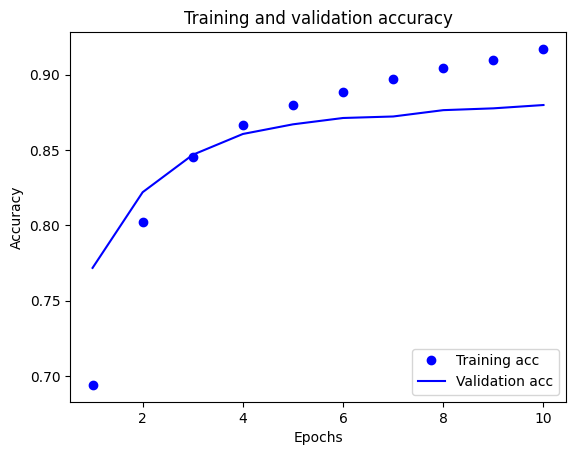

In [36]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [37]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 10ms/step - loss: 0.5885 - accuracy: 0.5000
0.5
